# Setup

In [ ]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Generate Data

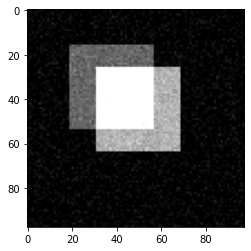

In [ ]:
input = np.zeros((33, 33))
input[2, 5] = 0.4
input[12, 17] = 0.7

a,b= np.meshgrid(np.linspace(-1, 1, 66), np.linspace(-1, 1, 66))
rectangle = np.array(np.logical_and(np.abs(a) < 0.6, np.abs(b) < 0.6),dtype='float32') 

Img = scipy.signal.convolve2d(input, rectangle)
plt.imshow(Img)

#IMG=np.stack((Img,) * 1, axis=-1)
IMG_T=torch.FloatTensor(Img)
IMG_T.shape
IMG_T2 = torch.unsqueeze(IMG_T, dim=0)
IMG_T2.shape
noisyImg = np.clip(Img + np.random.normal(scale=0.05, size=IMG_T2.shape), 0, 1).astype(np.float32) # adding noise from normal distribution
noisyImg_T=torch.FloatTensor(noisyImg)
noisyImg_T.shape
plt.imshow(noisyImg_T[0], cmap='gray')
clean=IMG_T2.unsqueeze(0)
noisy=noisyImg_T.unsqueeze(0)

In [ ]:
noisy.shape

torch.Size([1, 1, 98, 98])

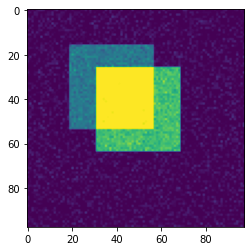

In [ ]:
plt.imshow(noisy[0][0])

In [ ]:
torch.max(noisy)

tensor(1.)

In [ ]:
class Anet(nn.Module):
    def __init__(self, channel=4):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(97,1),padding=(48,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,97),padding=(0,48), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =F.relu(self.conv1(x))
        out = F.relu(self.conv2(x1))
        #out = self.conv2(x2)
        #out = F.relu(self.conv2(x2))
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 98, 98)
A_net(x).shape

torch.Size([1, 1, 98, 98])

In [ ]:
from zmq import device
## reshape the tensors to a matrix

## inner dim =4
[4, 1, 98, 1]
[1,4, 1, 98]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV

## getting singular values

def my_singular(U, V):
  UV=my_outer(U, V)
  #_,Sigma,_=np.array(torch.svd_lowrank(UV, q=4, niter=2, M=None).to('cpu').detach())
  return np.array(torch.linalg.svdvals(UV).to('cpu').detach())
  

In [ ]:
def plot_epoch(recon_np,noisyImg1, Img):
  #if i % 50 == 0:
    fig = plt.figure(figsize=(7, 7))
    rows = 2
    columns = 2
    plt.subplot(rows, columns, 1)
    #recon_np = recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy()
    plt.imshow(recon_np, cmap='gray')
    plt.axis('off')
    plt.title("recon")
    plt.subplot(rows, columns, 2)
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.title("Img")
    plt.subplot(rows, columns, 3)
    plt.imshow(noisyImg1, cmap='gray')
    plt.axis('off')
    plt.title("Img+Noise")
    plt.show()
    plt.show()

> ### Training Function








In [ ]:
def recon(noisy, clean, alpha=0., iterations=100000, lr=1.e-2, gpu=True):
  import time

  cuda = torch.device('cuda') 

  A_net = Anet()
  x = torch.randn(1, 1, 98, 98)

  if gpu:
    A_net = A_net.to(cuda)
    x = x.to(cuda)
    noisy = noisy.to(cuda)
    clean = clean.to(cuda)

    #U=U.to(cuda)
    #V=V.to(cuda)
  
  optimizer = optim.SGD(A_net.parameters(), lr=lr)

  Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel  = [], [], [], [], [],[], [], [], []

  start = time.time()
  for i in tqdm(range(iterations)):

    recon = A_net(x)
    
    l2_norm = sum(p.pow(2.0).sum() for p in A_net.parameters()) #L2 norm of weights (p**2)
    U, V=[ p for p in A_net.parameters()]  ## get the kernels

    loss_recon = mse(recon, noisy)
    Loss_Rec.append(loss_recon.item())
    
    loss_regu = alpha * l2_norm
    Loss_Reg.append(loss_regu.item())

    loss = loss_recon + loss_regu
    Loss.append(loss.item())

    error = mse(recon, clean)
    Error.append(error.item())
    Recons.append(recon)
    
    U_kernel.append(U)
    V_kernel.append(V)
    UV_outer.append(my_outer(U, V))
    S_values.append(my_singular(U, V))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if i % 10000 == 0:
      plot_epoch(recon[0].squeeze(0).permute(1, 0).to('cpu').detach().numpy(), noisyImg_T[0], Img)
  end = time.time()
  print(f"ending optimization in: {((end-start)/60):.3f} mins")
  

  return Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel

# Reco for different Alpha

0.0


  0%|          | 0/50000 [00:00<?, ?it/s]

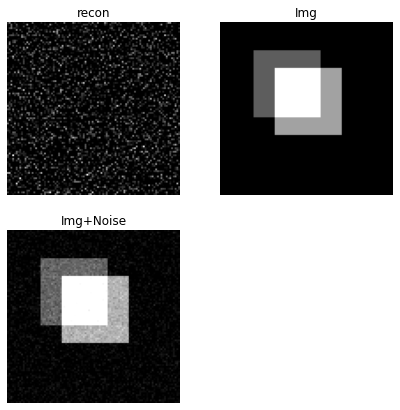

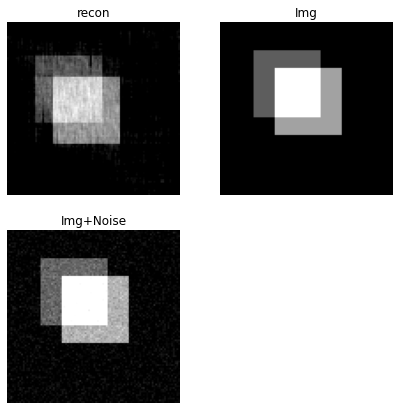

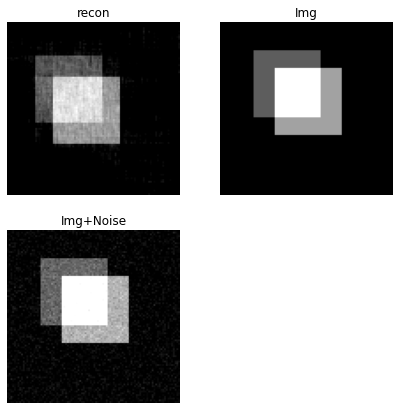

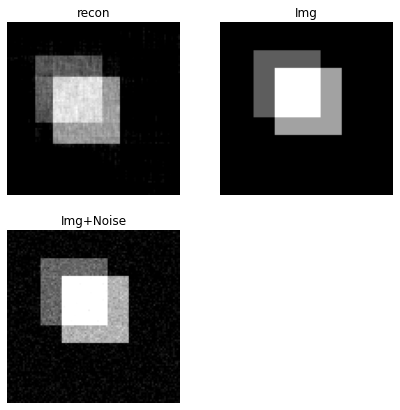

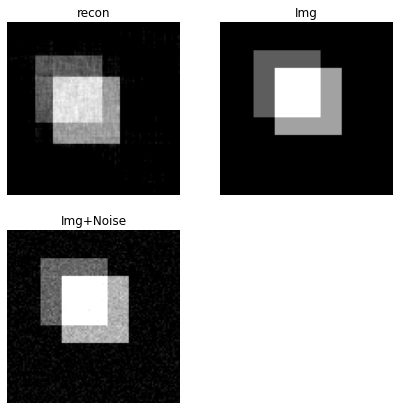

ending optimization in: 3.587 mins
0.05


  0%|          | 0/50000 [00:00<?, ?it/s]

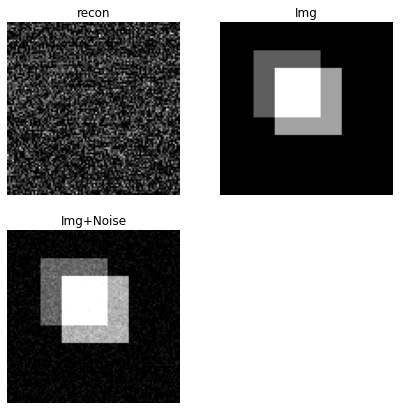

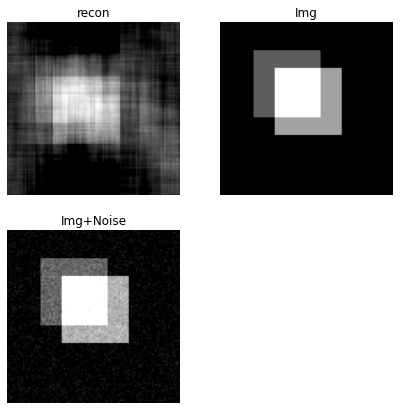

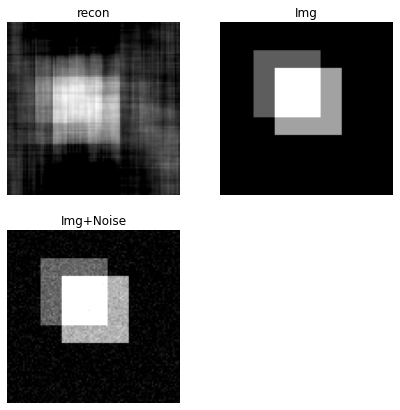

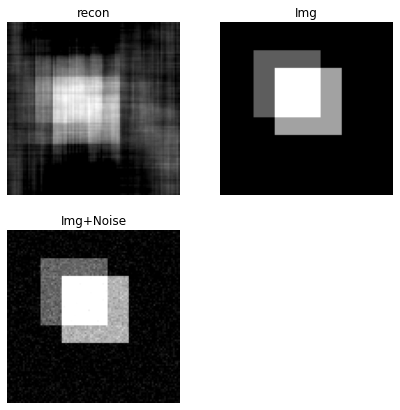

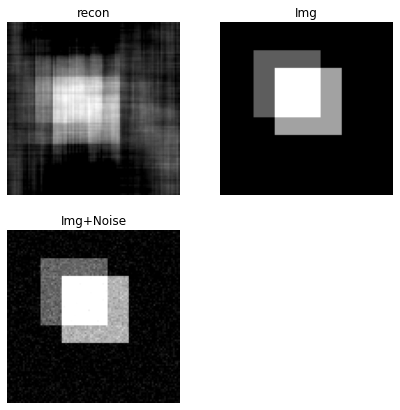

ending optimization in: 3.454 mins
0.1


  0%|          | 0/50000 [00:00<?, ?it/s]

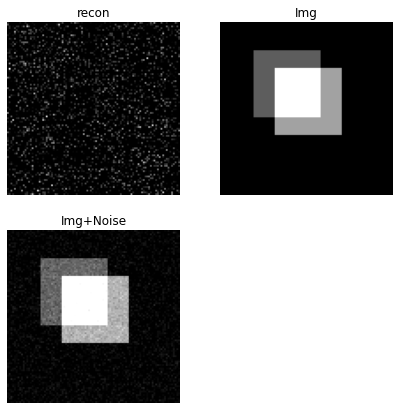

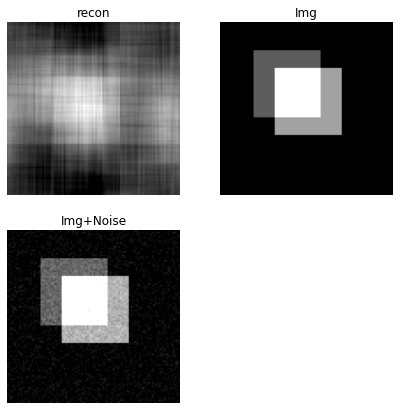

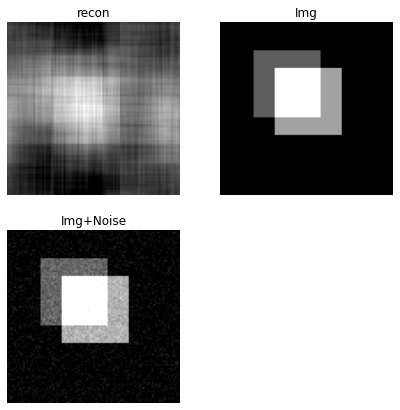

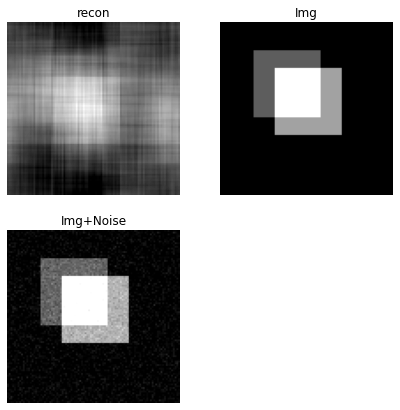

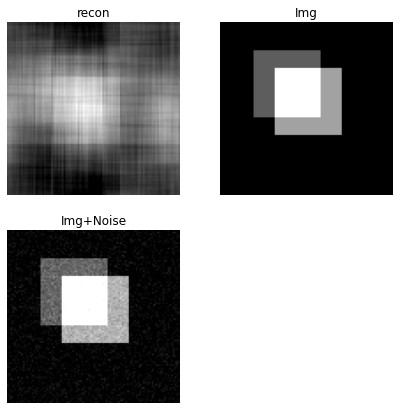

ending optimization in: 3.308 mins


In [ ]:
from numpy.ma.core import outer
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel = [], [], [], [], [],[], [], [], []

#Adapot alpha here!!!!
Alpha = np.linspace(0,0.1,3)

for alpha in Alpha:

  print(alpha)
  # lr 1.e-1 is too large
  # ->need more iterations ~ maybe 50000 are too many? 
  loss_rec, loss_reg, loss, error, s, outer, Recs, U_ker, V_ker = recon(noisy, clean, gpu=True , alpha=alpha, iterations=50000)

  Loss_Rec.append(loss_rec)
  Loss_Reg.append(loss_reg)
  Loss.append(loss)
  Error.append(error)
  S_values.append(s)
  UV_outer.append(outer)
  Recons.append(Recs)
  U_kernel.append(U_ker)
  V_kernel.append(V_ker)  
    
Loss_Rec=np.array(Loss_Rec)
Loss_Reg=np.array(Loss_Reg)
Loss=np.array(Loss)
Error=np.array(Error)
#UV_kernel=UV_kernel.cpu()
Sigma_arr=np.array(S_values)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [ ]:
#save files
np.save("/content/drive/My Drive/Loss_Rec.npy", Loss_Rec)
np.save("/content/drive/My Drive/Loss_Reg.npy", Loss_Reg)
np.save("/content/drive/My Drive/Loss.npy",Loss)
np.save("/content/drive/My Drive/Error.npy", Error)
np.save("/content/drive/My Drive/Alpha.npy", Alpha)
np.save("/content/drive/My Drive/Sigma.npy", Sigma)

# Load files and Plotting

In [ ]:
Loss_Rec= np.load("/content/drive/My Drive/Loss_Rec.npy")
Loss_Reg= np.load("/content/drive/My Drive/Loss_Reg.npy")
Loss= np.load("/content/drive/My Drive/Loss.npy")
Error= np.load("/content/drive/My Drive/Error.npy")
Alpha= np.load("/content/drive/My Drive/Alpha.npy")
Sigma= np.load("/content/drive/My Drive/Sigma.npy")

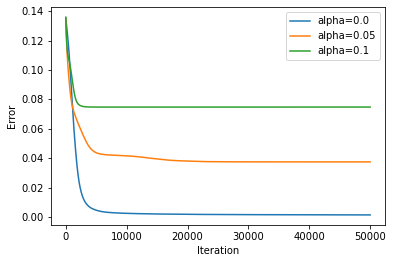

In [ ]:
for i in range(Alpha.shape[0]):
  plt.plot(Error[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()


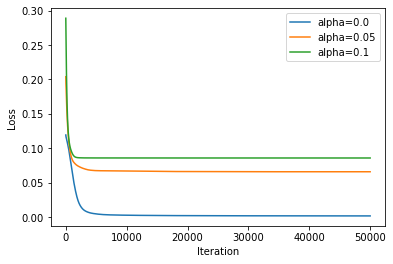

In [ ]:
for i in range(Alpha.shape[0]):
  plt.plot(Loss[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()
plt.show()


  0%|          | 0/100000 [00:00<?, ?it/s]

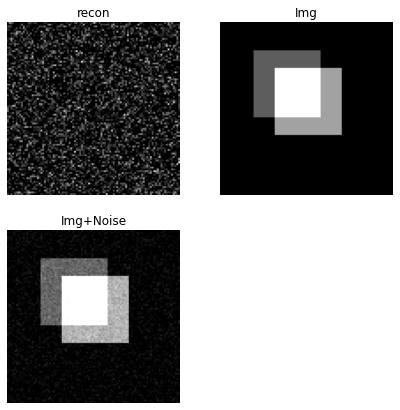

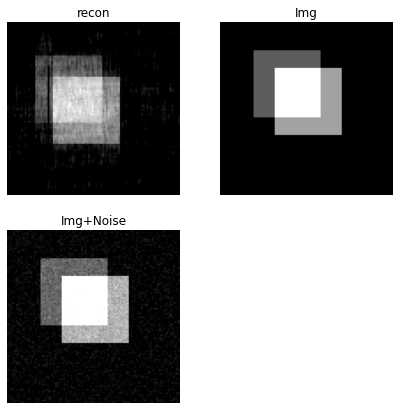

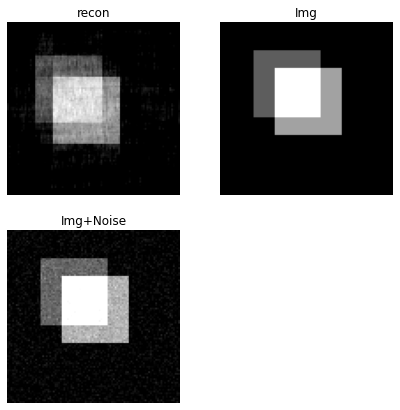

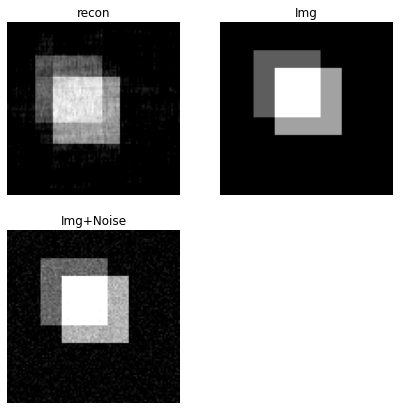

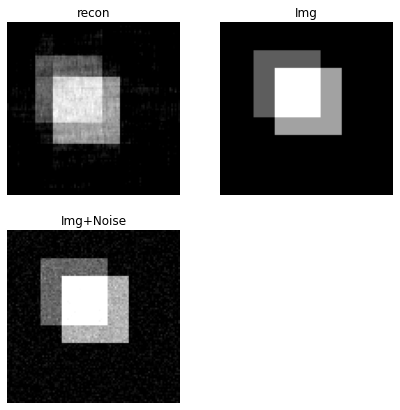

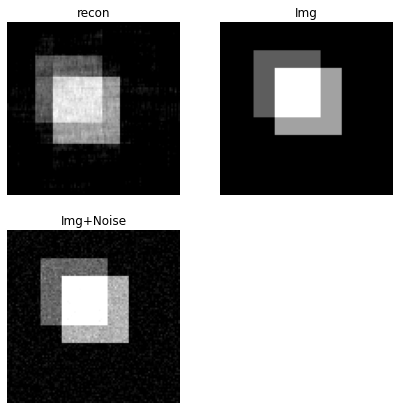

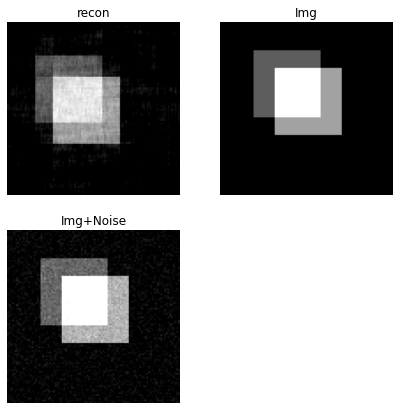

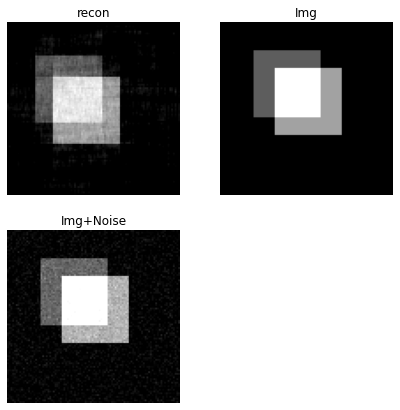

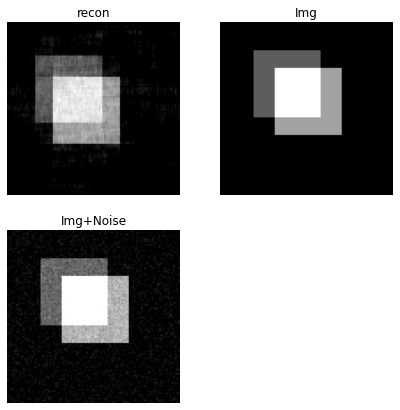

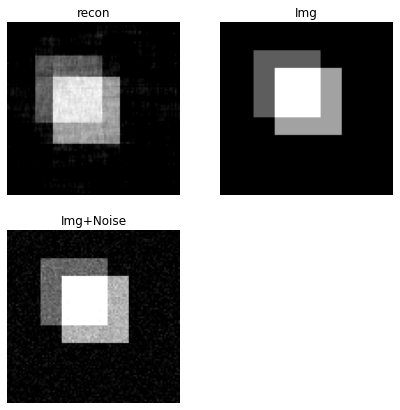

ending optimization in: 11.766 mins


In [ ]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel = recon(noisy, clean, gpu=True , alpha=0.001, iterations=100000) #channel 4 ## circular padding ##noise=0.05

Text(0.5, 1.0, 'Plot of singular values')

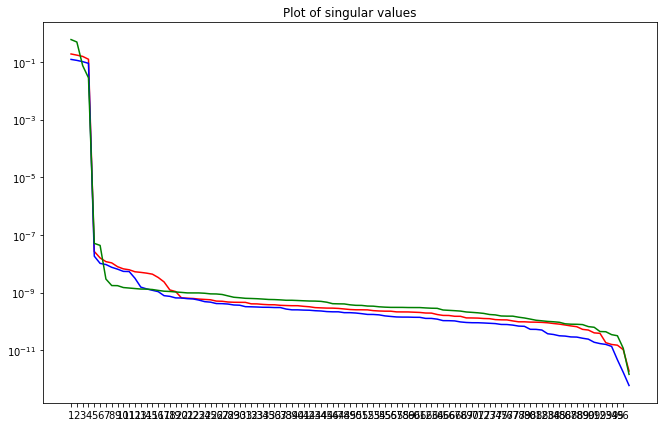

In [ ]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "red" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "blue" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "green" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'Plot of singular values')

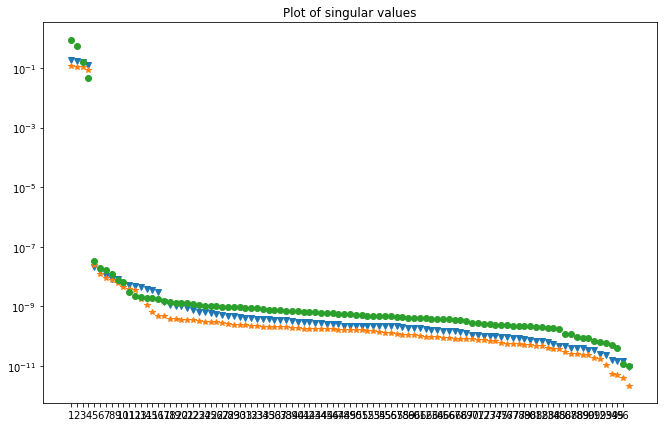

In [ ]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "v" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "*" )
  #plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[25000], "x" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'Plot of singular values')

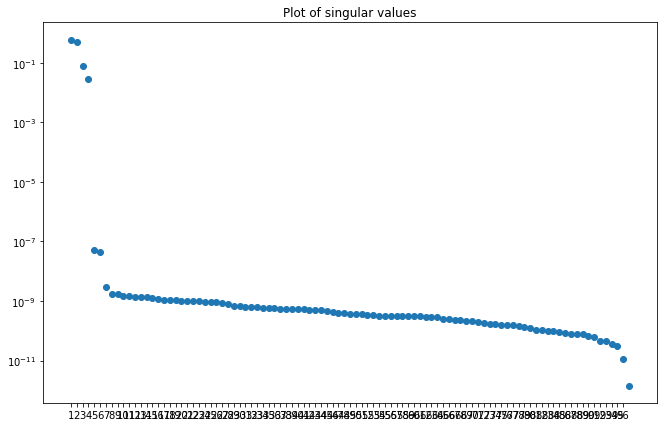

In [ ]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" )
plt.xticks(np.arange(1, len(S_values[0] + 1)))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
len(UV_outer)

100000

In [ ]:
UV_outer[0]

tensor([[-2.6476e-03, -8.8742e-04, -2.1873e-03,  ...,  7.3714e-04,
         -7.7856e-04, -1.5424e-03],
        [ 4.0049e-03,  2.0515e-03,  4.2723e-03,  ..., -1.9797e-03,
          5.8668e-05, -2.8237e-04],
        [-3.1653e-04, -9.8192e-04, -7.7711e-04,  ..., -2.8758e-03,
         -2.8163e-04,  7.5634e-04],
        ...,
        [-2.9006e-03, -4.5669e-04, -2.3317e-04,  ...,  1.2776e-03,
         -3.1255e-05, -3.2230e-03],
        [-2.9062e-03, -2.0662e-03, -3.4441e-03,  ..., -3.9016e-03,
         -1.9031e-03, -1.0077e-03],
        [-5.1486e-04,  1.0360e-03,  4.3367e-03,  ..., -1.4106e-04,
          8.3822e-04, -4.5977e-03]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
 np.linalg.matrix_rank(UV_outer[99000].cpu().detach().numpy())

4

In [ ]:
kernel=UV_outer[99000].cpu().detach()

In [ ]:
kernel.shape

torch.Size([97, 97])

In [ ]:
kernel

tensor([[0.0017, 0.0050, 0.0029,  ..., 0.0077, 0.0085, 0.0069],
        [0.0011, 0.0052, 0.0030,  ..., 0.0068, 0.0080, 0.0061],
        [0.0013, 0.0040, 0.0022,  ..., 0.0066, 0.0073, 0.0057],
        ...,
        [0.0012, 0.0028, 0.0013,  ..., 0.0059, 0.0061, 0.0049],
        [0.0019, 0.0043, 0.0025,  ..., 0.0079, 0.0087, 0.0068],
        [0.0002, 0.0037, 0.0010,  ..., 0.0069, 0.0068, 0.0051]])

In [ ]:
_,Sigma,_=torch.svd_lowrank(kernel, q=3, niter=2, M=None)

Text(0.5, 1.0, 'Plot of singular values')

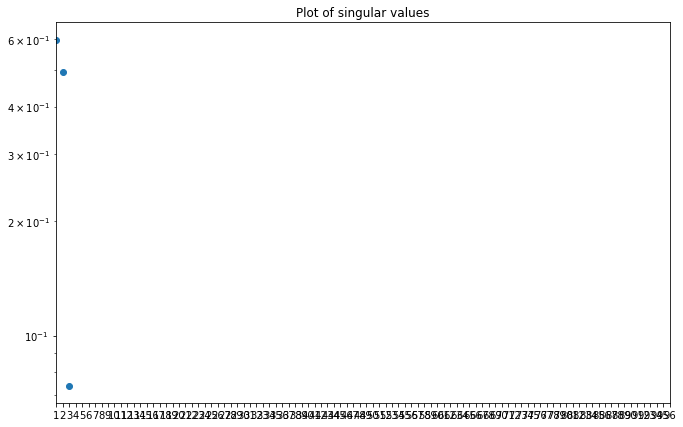

In [ ]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(Sigma) + 1),Sigma, "o" )
plt.xticks(np.arange(1, 97))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
_,Sigma,_=torch.svd_lowrank(kernel, q=4, niter=2, M=None)

Text(0.5, 1.0, 'Plot of singular values')

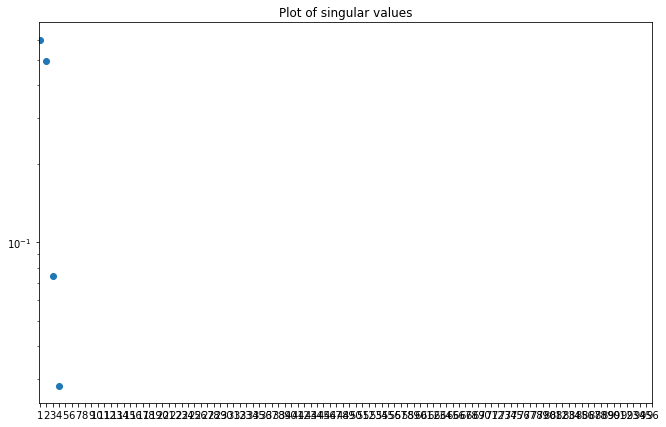

In [ ]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(Sigma) + 1),Sigma, "o" )
plt.xticks(np.arange(1, 97))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
len(Recons)

100000

In [ ]:
Recons[99000].shape

torch.Size([1, 1, 98, 98])

In [ ]:
rec_f=Recons[99000].cpu().detach()

In [ ]:
rec_f.shape

torch.Size([1, 1, 98, 98])

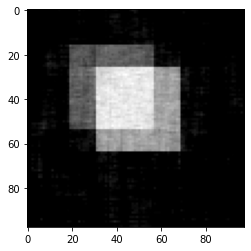

In [ ]:
plt.imshow(rec_f[0][0], cmap="gray")

In [ ]:
 np.linalg.matrix_rank(rec_f[0][0])

90

In [ ]:
U, s, V = np.linalg.svd(rec_f[0][0], full_matrices=False)

In [ ]:
len(s)

98

Text(0.5, 1.0, 'Plot of singular values')

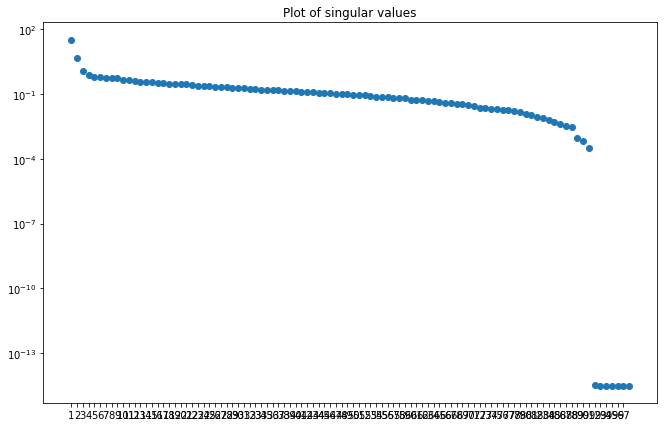

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
U, s, V = np.linalg.svd(Img, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

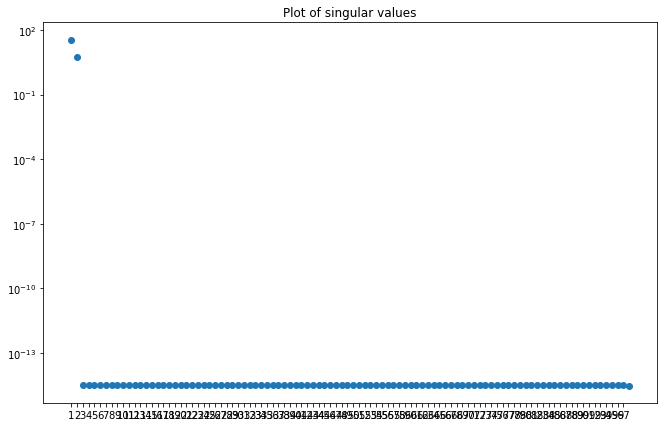

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
UV_outer

In [ ]:
UV_kernel=UV_outer[99000].cpu().detach()

In [ ]:
UV_kernel.shape

torch.Size([97, 97])

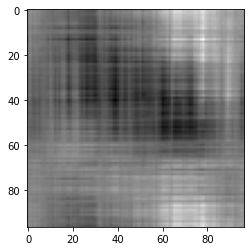

In [ ]:
plt.imshow(UV_kernel, cmap="gray")

In [ ]:
U, s, V = np.linalg.svd(UV_kernel, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

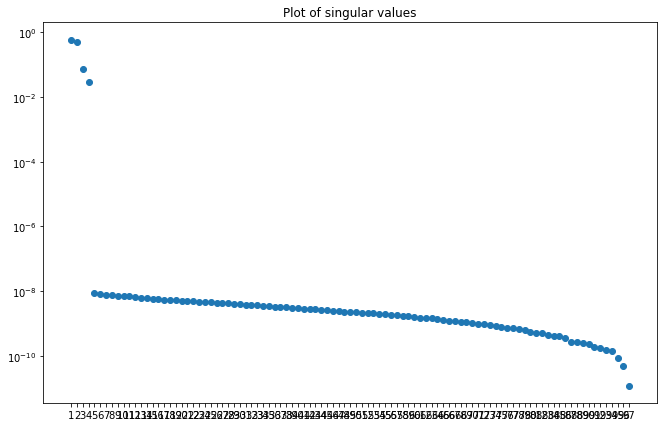

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
UV_kernel=np.array(UV_kernel)

In [ ]:
UV_kernel.shape

(97, 97)

In [ ]:
UV_kernel_transformed= np.fft.fft2(UV_kernel, axes=[0,1])

In [ ]:
U, s, V = np.linalg.svd(UV_kernel_transformed, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

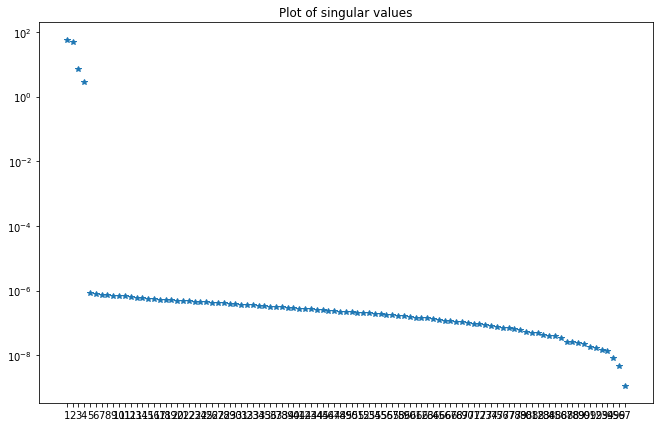

In [ ]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "*" )
plt.xticks(np.arange(1, 98))
plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
U, s, V = np.linalg.svd(noisyImg, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

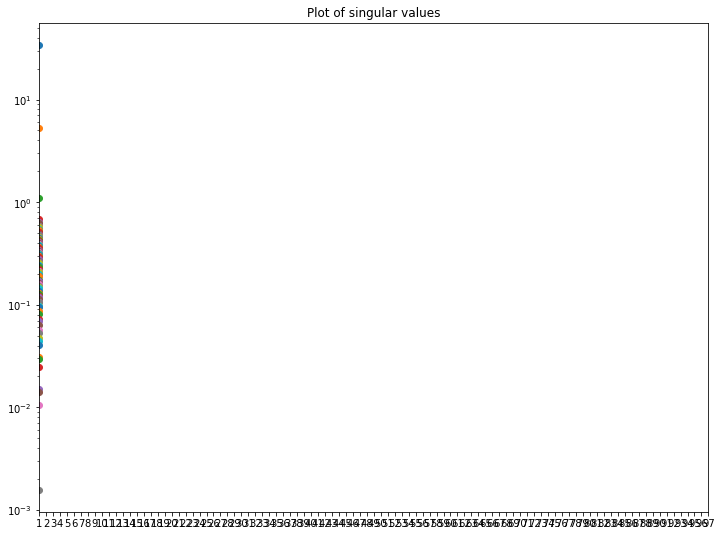

In [ ]:
plt.figure(figsize= (12,9))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
plt.yscale("log")
plt.title("Plot of singular values")